Using device: cuda

Training PINN...


/home/adil/.anaconda3/envs/llm/lib/python3.11/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.157821
Epoch 50, Loss: 0.053857
Epoch 100, Loss: 0.035428
Epoch 150, Loss: 0.022219
Epoch 200, Loss: 0.013673
Epoch 250, Loss: 0.005158
Epoch 300, Loss: 0.008023
Epoch 350, Loss: 0.004473
Epoch 400, Loss: 0.004723
Epoch 450, Loss: 0.008981

Training Pure NN...
Epoch 0, Loss: 0.151167
Epoch 50, Loss: 0.015840
Epoch 100, Loss: 0.008206
Epoch 150, Loss: 0.005546
Epoch 200, Loss: 0.003664
Epoch 250, Loss: 0.004851
Epoch 300, Loss: 0.003628
Epoch 350, Loss: 0.002546
Epoch 400, Loss: 0.001462
Epoch 450, Loss: 0.002518

Evaluating Interpolation Cases:
Interpolation Alpha 0.75: PINN MSE 0.034832, NN MSE 0.194842
Interpolation Alpha 1.25: PINN MSE 0.093932, NN MSE 0.488928
Interpolation Alpha 1.75: PINN MSE 0.181937, NN MSE 1.159940

Evaluating Extrapolation Cases:
Extrapolation Alpha 2.5: PINN MSE 0.368170, NN MSE 2.580990
Extrapolation Alpha 3.0: PINN MSE 0.528973, NN MSE 3.464711


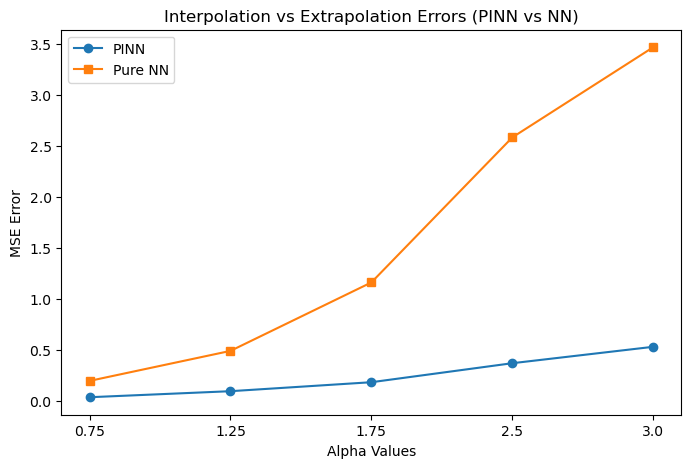

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define problem parameters
Lx, Ly = 1.0, 1.0  # Domain size
T = 1.0  # Final time
kappa = 0.1  # Thermal diffusivity

# Training and testing alpha values
train_alphas = np.linspace(0.5, 2.0, 10)  # Training range
test_alphas = np.array([0.75, 1.25, 1.75, 2.5, 3.0])  # Interpolation & extrapolation cases

# Define computational grid (Reduced size for speed)
Nx, Ny, Nt = 20, 20, 20
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
t = np.linspace(0, T, Nt)

X, Y, T_grid = np.meshgrid(x, y, t, indexing="ij")
X_tensor = torch.tensor(X.flatten(), dtype=torch.float32, device=device).unsqueeze(1)
Y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32, device=device).unsqueeze(1)
T_tensor = torch.tensor(T_grid.flatten(), dtype=torch.float32, device=device).unsqueeze(1)

# Define a neural network architecture
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 32), nn.SiLU(),
            nn.Linear(32, 32), nn.SiLU(),
            nn.Linear(32, 32), nn.SiLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, y, t, alpha):
        inputs = torch.cat((x, y, t, alpha), dim=1)
        return self.net(inputs)

# Define PINN Loss (includes PDE, initial & boundary conditions)
def pinn_loss(model, x, y, t, alpha):
    x.requires_grad = True
    y.requires_grad = True
    t.requires_grad = True

    u = model(x, y, t, alpha)

    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0],
                               x, torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True, retain_graph=True)[0],
                               y, torch.ones_like(u), create_graph=True)[0]

    pde_residual = u_t - kappa * (u_xx + u_yy)
    loss_pde = torch.mean(pde_residual ** 2)

    u_initial = model(x, y, torch.zeros_like(t), alpha)
    u_init_target = alpha * torch.sin(np.pi * x) * torch.sin(np.pi * y)
    loss_ic = torch.mean((u_initial - u_init_target) ** 2)

    loss_bc = torch.mean(model(torch.zeros_like(x), y, t, alpha)**2) + \
              torch.mean(model(torch.ones_like(x) * Lx, y, t, alpha)**2) + \
              torch.mean(model(x, torch.zeros_like(y), t, alpha)**2) + \
              torch.mean(model(x, torch.ones_like(y) * Ly, t, alpha)**2)

    return loss_pde + loss_ic + loss_bc

# Define Pure Neural Network Loss (Only Initial Condition)
def nn_loss(model, x, y, t, alpha):
    u_initial = model(x, y, torch.zeros_like(t), alpha)
    u_init_target = alpha * torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean((u_initial - u_init_target) ** 2)

# Train both models
def train_model(model, loss_fn, epochs=500, batch_size=2000):
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    for epoch in range(epochs):
        loss_total = 0.0
        random_alphas = np.random.choice(train_alphas, size=3, replace=False)
        
        for alpha in random_alphas:
            alpha_tensor = torch.full_like(X_tensor[:batch_size], alpha, device=device)
            x_batch, y_batch, t_batch = X_tensor[:batch_size], Y_tensor[:batch_size], T_tensor[:batch_size]

            optimizer.zero_grad()
            loss = loss_fn(model, x_batch, y_batch, t_batch, alpha_tensor)
            loss.backward()
            optimizer.step()
            loss_total += loss.item()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss_total / len(random_alphas):.6f}")

# Train PINN
pinn_model = NeuralNet().to(device)
print("\nTraining PINN...")
train_model(pinn_model, pinn_loss)

# Train Pure NN (No PDE constraints)
nn_model = NeuralNet().to(device)
print("\nTraining Pure NN...")
train_model(nn_model, nn_loss)

# Evaluate models
def analytical_solution(x, y, t, alpha):
    return alpha * np.exp(-2 * np.pi**2 * kappa * t) * np.sin(np.pi * x) * np.sin(np.pi * y)

def evaluate(models, alpha_values, label):
    errors = {name: [] for name in models}
    
    for alpha in alpha_values:
        alpha_tensor = torch.full_like(X_tensor, alpha, device=device)

        u_exact = analytical_solution(X, Y, T_grid, alpha)
        for name, model in models.items():
            u_pred = model(X_tensor, Y_tensor, T_tensor, alpha_tensor).cpu().detach().numpy()
            error = np.mean((u_pred - u_exact.flatten()) ** 2)
            errors[name].append(error)

        print(f"{label} Alpha {alpha}: PINN MSE {errors['PINN'][-1]:.6f}, NN MSE {errors['Pure NN'][-1]:.6f}")
    
    return errors

print("\nEvaluating Interpolation Cases:")
interpolation_errors = evaluate({"PINN": pinn_model, "Pure NN": nn_model}, [0.75, 1.25, 1.75], "Interpolation")

print("\nEvaluating Extrapolation Cases:")
extrapolation_errors = evaluate({"PINN": pinn_model, "Pure NN": nn_model}, [2.5, 3.0], "Extrapolation")

# Plot comparison
alphas_test = ["0.75", "1.25", "1.75", "2.5", "3.0"]
plt.figure(figsize=(8, 5))
plt.plot(alphas_test, interpolation_errors["PINN"] + extrapolation_errors["PINN"], label="PINN", marker='o')
plt.plot(alphas_test, interpolation_errors["Pure NN"] + extrapolation_errors["Pure NN"], label="Pure NN", marker='s')
plt.xlabel("Alpha Values")
plt.ylabel("MSE Error")
plt.title("Interpolation vs Extrapolation Errors (PINN vs NN)")
plt.legend()
plt.show()
